# Olfaction Controller

I am using here a big part of the code seen in week3 of the exercises. First create an odor arena with one attractive odor source only.
## Odor source

In [1]:
import numpy as np

# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

## OdorArena

In [2]:
from flygym.arena import OdorArena

arena = OdorArena(
    odor_source=odor_source,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

### Place the fly
We use `HybridTurningNMF`Controller for turning of the fly.

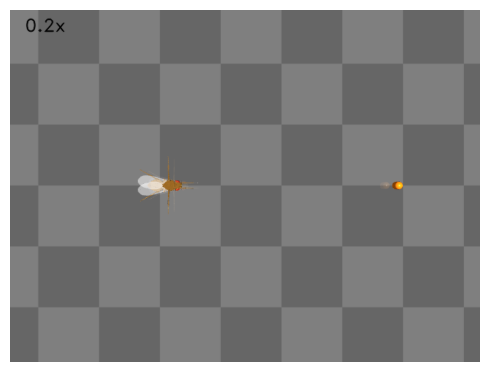

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
from flygym import Parameters, Camera, SingleFlySimulation, Fly
from flygym.examples.turning_controller import HybridTurningNMF
from flygym.simulation import Simulation
from hybrid_turning_fly import HybridTurningFly

Path("./outputs").mkdir(exist_ok=True)


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
timestep = 1e-4

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
fly_male = HybridTurningFly(
    name="male",
    timestep=timestep,
    enable_adhesion=True,
    enable_olfaction=True,
    spawn_pos=(6, 0, 0.5),
)

cam = Camera(
    fly=fly_male,
    camera_id="birdeye_cam",
)

sim = SingleFlySimulation(
    fly=fly_male,
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)
   
# sim = HybridTurningNMF(
#     fly=fly_male,
#     sim_params=sim_params,
#     arena=arena,
#     spawn_pos=(0, 0, 0.2),
#     contact_sensor_placements=contact_sensor_placements,
# )

for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")
fig.savefig("./outputs/olfaction_env.png")

## Controller for odor taxis

Let's design a simple hand-tuned controller for odor-guided taxis. We start by calculating the left-right asymmetry of the odor intensity $I$ for each odor $o$:

$$
\Delta I_o = \frac{I_\text{left,o} - I_\text{right,o}}{(I_\text{left,o} + I_\text{right,o}) / 2}
$$

Then, we multiply $\Delta I_o$ by a gain $\gamma_o$ for each odor dimension and take the sum $s$. Attractive and aversive odors will have different signs in their gains.

$$
s = \sum_{o} \gamma_o \Delta I_o
$$

We transform $s$ nonlinearly to avoid overly drastic turns when the asymmetry is subtle and to crop it within the range [0, 1). This gives us a turning bias $b$:

$$
b = \tanh(s^2)
$$

Then, we modulate the descending signal $\delta$ based on $b$ and the sign of $s$:

$$
\delta_\text{left} = 
    \begin{cases}
    \delta_\text{max} & \text{if } s>0\\
    \delta_\text{max} - b(\delta_\text{max} - \delta_\text{min})  & \text{otherwise}
    \end{cases}
    \qquad
    \delta_\text{right} = 
    \begin{cases}
    \delta_\text{max} - b(\delta_\text{max} - \delta_\text{min}) & \text{if } s>0\\
    \delta_\text{max}  & \text{otherwise}
    \end{cases}
$$

where, $\delta_\text{min}$, $\delta_\text{max}$ define the range of the descending signal. Here, we will use the following parameters:

- $\gamma_\text{attractive} = -500$ (negative ipsilateral gain leads to positive taxis)
- $\gamma_\text{aversive} = 80$ (positive ipsilateral gain leads to negative taxis)
- $\delta_\text{min} = 0.2$
- $\delta_\text{max} = 1$

Finally we set the descending signal $\delta$ to zero if the intensity of the attractive odor is above a threshold (i.e. the fly reached a certain distance to the odor source).

$$
\delta_\text{left} = 
    \begin{cases}
    0 & \text{if } I_{attractive}>\text{threshold}\\
    \delta_\text{left} & \text{otherwise}
    \end{cases}
    \qquad
    \delta_\text{right} = 
    \begin{cases}
    0 & \text{if } I_{attractive}>\text{threshold}\\
    \delta_\text{right}  & \text{otherwise}
    \end{cases}
$$

As before, we will recalculate the steering signal every 0.05 seconds. Let's implement this in Python:

In [4]:
from tqdm import trange

# Gains for the two odors (negative = attractive, positive = aversive)
gains = np.array([-500, 80])
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

obs_hist = []
odor_history = []
obs, _ = sim.reset()
reached_odor_source = False
for i in trange(num_decision_steps):
    I_reshaped = obs["odor_intensity"].reshape((odor_dimensions, 2, 2))
    I = np.average(I_reshaped, axis=1, weights=[120, 1200])

    # Calculate the left-right asymmetry in the odor intensities
    I_l, I_r = I[:, 0], I[:, 1]
    denom = (I_l + I_r) / 2
    denom[denom == 0] = 1  # Avoid division by zero
    delta_I = (I_l - I_r) / denom

    # Calculate the weighted sum of the asymmetries for each odor
    s = np.dot(gains, delta_I)

    # Calculate the turning bias
    b = np.tanh(s**2)

    control_signal = np.ones((2,))
    side_to_modulate = int(s > 0)
    modulation_amount = b * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    # Set control signal to zero if attractive odor intensity is above a threshold
    if(I_l[0] > 0.5 or I_r[0] > 0.5):  # Extracts the attractive odor intensity
        control_signal = np.zeros((2,))
        if not reached_odor_source:
            reached_odor_source = True
            print("Reached odor source")
        

    for j in range(physics_steps_per_decision_step):
        obs, _, _, _, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

    # # Stop when the fly is within 2mm of the attractive odor source
    # if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
    #     break


 30%|███       | 30/100 [01:34<03:49,  3.28s/it]

Reached odor source


 47%|████▋     | 47/100 [02:33<02:52,  3.26s/it]


KeyboardInterrupt: 

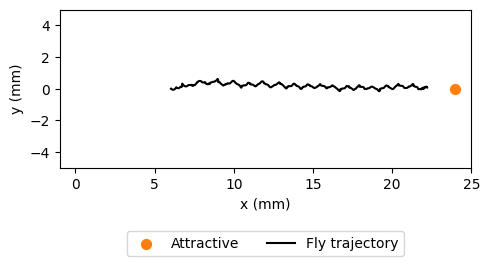

In [5]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
# ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 25)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig("./outputs/odor_taxis_trajectory.png")

In [6]:
print(obs["odor_intensity"])
print(f"Odor intensity reshaped:\n {obs['odor_intensity'].reshape((odor_dimensions, 2, 2))}")
print(f"I: {I}")
print("")
print(f"I reshape: {I_reshaped}")
print("")
print(f"I_l: {I_l}, I_r: {I_r}")
print(I_reshaped.shape)
print(I.shape)

[[0.30923462 0.27170345 0.6267971  0.58063376]
 [0.         0.         0.         0.        ]]
Odor intensity reshaped:
 [[[0.30923462 0.27170345]
  [0.6267971  0.58063376]]

 [[0.         0.        ]
  [0.         0.        ]]]
I: [[0.60019615 0.55408792]
 [0.         0.        ]]

I reshape: [[[0.31028602 0.27220127]
  [0.62918717 0.5822766 ]]

 [[0.         0.        ]
  [0.         0.        ]]]

I_l: [0.60019615 0.        ], I_r: [0.55408792 0.        ]
(2, 2, 2)
(2, 2)


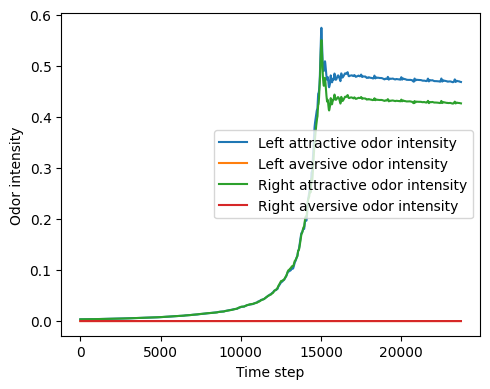

In [7]:
#plot histroy of observations odors intensities
odor_history = [np.average(obs_hist[i]["odor_intensity"].reshape((odor_dimensions, 2, 2)), axis=1) for i in range(len(obs_hist))]
odor_l_history = [odor_history[i][:, 0] for i in range(len(odor_history))]
odor_r_history = [odor_history[i][:, 1] for i in range(len(odor_history))]

plot_odor_l = np.array(odor_l_history)
plot_odor_r = np.array(odor_r_history)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.plot(plot_odor_l, label=["Left attractive odor intensity", "Left aversive odor intensity"])
ax.plot(plot_odor_r, label=["Right attractive odor intensity", "Right aversive odor intensity"])
ax.set_xlabel("Time step")
ax.set_ylabel("Odor intensity")
ax.legend()
plt.show()



In [8]:
cam.save_video("./outputs/olfaction_env.mp4")